### Notebook to analyse *.nc files (with single variables) 

In [1]:
#TODO: extend to multiple variables 

# Imports
import cartopy
import matplotlib.pyplot as plt
import numpy as np
import iris
from iris.analysis import Aggregator
import iris.plot as iplt
import iris.quickplot as qplt
import iris.coord_categorisation
from iris.util import rolling_window
from ruamel import yaml
from tqdm import tqdm
from ruamel.yaml import ruamel
import warnings

Utilizing 
https://scitools.org.uk/iris/docs/latest/examples/General/custom_aggregation.html

#### Some initial data probing

In [2]:
# test for multi model execution


data = '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output/data_mpi-esm1-2-hr.yml'

print(data)

with open(data, 'r') as stream:
        try:
            filepaths = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
print(filepaths)

/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output/data_mpi-esm1-2-hr.yml
['/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output_mpi-esm1-2-hr_ssp126_20612070.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output_mpi-esm1-2-hr_ssp126_20512060.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output_mpi-esm1-2-hr_ssp126_20312040.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output_mpi-esm1-2-hr_ssp126_20152020.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output_mpi-esm1-2-hr_ssp126_20212030.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output_mpi-esm1-2-hr_ssp126_20712080.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output_mpi-esm1-2-hr_ssp126_20912100.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output_mpi-esm1-2-hr_ssp126_20812090.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200304/ssp126/output_mpi-esm1-2-hr_ssp

#### Some statistics

In [3]:
# load data
# function to filter for specific variables

def filter_cube (cube,variablename):
    return cube.extract(variablename)
   
variablename = "approx_fresh_daily_snow_height"
cubelist = iris.load(filepaths,variablename)
print(cubelist)
constrained_cubes = iris.cube.CubeList()
# restrict on latitudes above northern tropic
northernTropic = iris.Constraint(latitude=lambda v: 23 <= v)

for i_cube in tqdm(cubelist):
    constrained_cubes.append(i_cube.extract(northernTropic))
    
print (constrained_cubes)   

100%|██████████| 9/9 [00:00<00:00, 150.15it/s]

0: approx_fresh_daily_snow_height / (1) (time: 2192; latitude: 360; longitude: 720)
1: approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 360; longitude: 720)
2: approx_fresh_daily_snow_height / (1) (time: 3653; latitude: 360; longitude: 720)
3: approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 360; longitude: 720)
4: approx_fresh_daily_snow_height / (1) (time: 3653; latitude: 360; longitude: 720)
5: approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 360; longitude: 720)
6: approx_fresh_daily_snow_height / (1) (time: 3653; latitude: 360; longitude: 720)
7: approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 360; longitude: 720)
8: approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 360; longitude: 720)
0: approx_fresh_daily_snow_height / (1) (time: 2192; latitude: 134; longitude: 720)
1: approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 134; longitude: 720)
2: approx_fresh_daily_snow_height / (1) (time: 3653; latitude: 134; longitud

In [4]:
analyisis_cubes = constrained_cubes
# always use analysis cubes, input can be changed here and only here
 # add some auxilary coordinates
for i_cube in tqdm(analyisis_cubes):
  iris.coord_categorisation.add_year(i_cube, 'time', name='year')

100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


In [5]:
# ignore warnings
warnings.simplefilter("ignore")

In [6]:
# function to generate for polynomial fit
def quadratic_fit (cube):
 # Calculate a polynomial fit to the data at this time series.
    x_points = cube.coord('time').points
    y_points = cube.data
    degree = 2

    p = np.polyfit(x_points, y_points, degree)
    y_fitted = np.polyval(p, x_points)

    # Add the polynomial fit values to the time series to take
    # full advantage of Iris plotting functionality.
    long_name = 'degree_{}_polynomial_fit_of_{}'.format(degree, cube.name())
    fit = iris.coords.AuxCoord(y_fitted, long_name=long_name,
                               units=cube.units)
    cube.add_aux_coord(fit, 0)

    iplt.plot(cube.coord('time'), cube, label='data')
    iplt.plot(cube.coord('time'),
              cube.coord(long_name),
              'g-', label='polynomial fit')
    title = 'degree_{}_polynomial_fit_of_{}'.format(degree, cube.name())
    plt.title(title)
    plt.legend(loc='best')



In [23]:
# some "country" statistics

from country_bounding_boxes import (
      country_subunits_containing_point,
      country_subunits_by_iso_code
    )


# function to restrict cubes on bounding box

def cube_from_bounding_box (cube, bounding_box):
    return cube.intersection(longitude=(bounding_box[0],bounding_box[2])).intersection(latitude=(bounding_box[1],bounding_box[3]))

country = 'US'
country_dict = {}
for c in tqdm(country_subunits_by_iso_code(country)):
    print (c.name)
    country_dict[str(c.name)]=c.bbox

contingentUS_box = country_dict['U.S.A.']


# loop to create list of country limited cubes
us_cubes = iris.cube.CubeList()
for i_cube in tqdm(cubelist):
    us_cubes.append(cube_from_bounding_box(i_cube,contingentUS_box))

country = 'CN'
country_dict = {}
for c in tqdm(country_subunits_by_iso_code(country)):
    print (c.name)
    country_dict[str(c.name)]=c.bbox
china_box = country_dict ["China"]

# loop to create list of country limited cubes
china_cubes = iris.cube.CubeList()
for i_cube in tqdm(cubelist):
    china_cubes.append(cube_from_bounding_box(i_cube,china_box))

country = 'DE'
country_dict = {}
for c in tqdm(country_subunits_by_iso_code(country)):
    print (c.name)
    country_dict[str(c.name)]=c.bbox
germany_box = country_dict ["Germany"]
# loop to create list of country limited cubes
germany_cubes = iris.cube.CubeList()
for i_cube in tqdm(cubelist):
    germany_cubes.append(cube_from_bounding_box(i_cube,germany_box))

4it [00:00, 1604.86it/s]
100%|██████████| 9/9 [00:00<00:00, 210.41it/s]
2it [00:00, 7358.43it/s]
100%|██████████| 9/9 [00:00<00:00, 311.79it/s]
1it [00:00, 5295.84it/s]
100%|██████████| 9/9 [00:00<00:00, 316.40it/s]

Hawaii
U.S.A.
Alaska
Alaska
Hainan
China
Germany


In [24]:
analysis_cubelist = germany_cubes   

def add_season(cubelist):
    copy_cubelist = cubelist
    print("add season coordinate")
    for i_cube in tqdm(copy_cubelist):
        iris.coord_categorisation.add_season(i_cube,'time')
        iris.coord_categorisation.add_season_year(i_cube, 'time', name='season_year')
    return copy_cubelist
    

Analysis for winter season:

In [25]:
# loop to plot country limited data graphs
def filter_season(cubelist,season):
    print("filter for "+season+" season")
    season_cubelist = iris.cube.CubeList()
    for i_cube in tqdm(cubelist):
        
        season_constr = iris.Constraint(season=season)
        season_cubelist.append(i_cube.extract(season_constr))
    return season_cubelist
    

In [26]:
# concatenate all country cubes by time
from iris.util import unify_time_units
from iris.experimental.equalise_cubes import equalise_attributes 
def unify_concatenate(cubelist):
    unify_time_units(cubelist)
    equalise_attributes(cubelist)
    
    return cubelist.concatenate_cube()

In [27]:
# add area bounds to enable area weighted mean:
def add_lon_lat_bounds (cube):
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()


In [28]:
def prepare_season_stats(cubelist,season):
    cubelist = add_season(cubelist)
    season_cubelist = filter_season(cubelist,season)
    season_cube = unify_concatenate(season_cubelist)
    add_lon_lat_bounds(season_cube)
    return season_cube

In [29]:
# definee method to plot cube statistics


def cube_stats (cube):

    print("Plot mean")    
    # loop to plot country limited data graphs

    # filter data for non-zero values



    aggregated = cube.aggregated_by(['season_year'],iris.analysis.MEAN)
    cube_grid_areas = iris.analysis.cartography.area_weights(aggregated)
    collapsed = aggregated.collapsed(('latitude',"longitude"),iris.analysis.MEAN,weights=cube_grid_areas)
    quadratic_fit(collapsed)
    plt.show()

    print("plot percentiles")
    percentiles = [99.9,99,97.5,95]
    for percentile in tqdm(percentiles):
        print("percentile: "+str(percentile))
        aggregated = cube.aggregated_by(['season_year'],iris.analysis.PERCENTILE,percent=[percentile])
        cube_grid_areas = iris.analysis.cartography.area_weights(aggregated)
        collapsed = aggregated.collapsed(('latitude',"longitude"),iris.analysis.MEAN,weights=cube_grid_areas)
        quadratic_fit(collapsed)
        plt.show()
    print("Plot for threshhold exceedances")    

    thresholds = [100,200,300,400,500,600,700,800,900,1000]

    for i_threshold in tqdm(thresholds):
        print(i_threshold)
        aggregated = cube.aggregated_by(['season_year'],iris.analysis.COUNT,
                                   function=lambda values: values > i_threshold)
        cube_grid_areas = iris.analysis.cartography.area_weights(aggregated)
        collapsed = aggregated.collapsed(('latitude',"longitude"),iris.analysis.MEAN,weights=cube_grid_areas)
        quadratic_fit(collapsed)
        plt.show()

    print("Plot max")    
    # loop to plot country limited data graphs
    aggregated = cube.aggregated_by(['season_year'],iris.analysis.MAX)
    collapsed = aggregated.collapsed(('latitude',"longitude"),iris.analysis.MEAN)
    quadratic_fit(collapsed)
    plt.show()

In [30]:
# from https://scitools.org.uk/iris/docs/latest/examples/General/SOI_filtering.html?highlight=time
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.

    Args:

    window: int
        The length of the filter window.

    cutoff: float
        The cutoff frequency in inverse time steps.

    """
    order = ((window - 1)// 2) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

In [31]:
window = 30
wgts = low_pass_weights(window, 1. / window) 


print(wgts)


[0.00033519 0.00148775 0.00364642 0.0069367  0.01139863 0.01697146
 0.02348769 0.03067779 0.03818578 0.04559453 0.05245881 0.05834268
 0.06285765 0.06569757 0.06666667 0.06569757 0.06285765 0.05834268
 0.05245881 0.04559453 0.03818578 0.03067779 0.02348769 0.01697146
 0.01139863 0.0069367  0.00364642 0.00148775 0.00033519]


In [32]:

warnings.simplefilter('default')
aggregated = winter_cube.aggregated_by(['season_year'],iris.analysis.MEAN)
winter_cube5 = aggregated.rolling_window('time', iris.analysis.SUM, len(wgts),weights=wgts)
quadratic_fit(winter_cube5.collapsed(('latitude',"longitude"),iris.analysis.MEAN))
plt.show()

NameError: name 'winter_cube' is not defined

In [33]:
#  cubelists for countries to compare need to be prepared beforehand due to individual naming of main parts of countries etc... TBD generalize
germany_winter = prepare_season_stats(germany_cubes,"djf")
print(germany_winter)



  0%|          | 0/9 [00:00<?, ?it/s]

add season coordinate


 33%|███▎      | 3/9 [00:00<00:00, 19.95it/s]

filter for djf season


100%|██████████| 9/9 [00:00<00:00, 17.92it/s]


approx_fresh_daily_snow_height / (1) (time: 7761; latitude: 15; longitude: 18)
     Dimension coordinates:
          time                            x               -              -
          latitude                        -               x              -
          longitude                       -               -              x
     Auxiliary coordinates:
          season                          x               -              -
          season_year                     x               -              -
     Attributes:
          contact: lennart.quante@pik-potsdam.de
          created_with: https://github.com/lquante/snow-processing by S. Willner & L. Quante


In [34]:
china_winter = prepare_season_stats(china_cubes,"djf")
print(china_winter)

  0%|          | 0/9 [00:00<?, ?it/s]

add season coordinate


 33%|███▎      | 3/9 [00:00<00:00, 20.10it/s]

filter for djf season


100%|██████████| 9/9 [00:00<00:00, 18.02it/s]


approx_fresh_daily_snow_height / (1) (time: 7761; latitude: 66; longitude: 123)
     Dimension coordinates:
          time                            x               -              -
          latitude                        -               x              -
          longitude                       -               -              x
     Auxiliary coordinates:
          season                          x               -              -
          season_year                     x               -              -
     Attributes:
          contact: lennart.quante@pik-potsdam.de
          created_with: https://github.com/lquante/snow-processing by S. Willner & L. Quante


In [ ]:
us_winter = prepare_season_stats(us_cubes,"djf")
print(us_winter)



  0%|          | 0/9 [00:00<?, ?it/s]

add season coordinate


 33%|███▎      | 3/9 [00:00<00:00, 19.93it/s]

filter for djf season


100%|██████████| 9/9 [00:00<00:00, 17.96it/s]


approx_fresh_daily_snow_height / (1) (time: 7761; latitude: 50; longitude: 115)
     Dimension coordinates:
          time                            x               -              -
          latitude                        -               x              -
          longitude                       -               -              x
     Auxiliary coordinates:
          season                          x               -              -
          season_year                     x               -              -
     Attributes:
          contact: lennart.quante@pik-potsdam.de
          created_with: https://github.com/lquante/snow-processing by S. Willner & L. Quante


Plot mean


/home/quante/.conda/envs/my_root/lib/python3.6/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


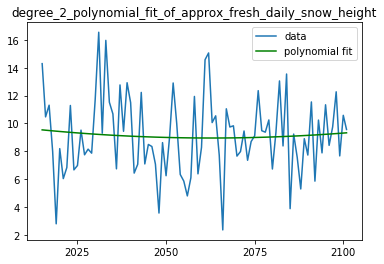

  0%|          | 0/4 [00:00<?, ?it/s]

plot percentiles
percentile: 99.9


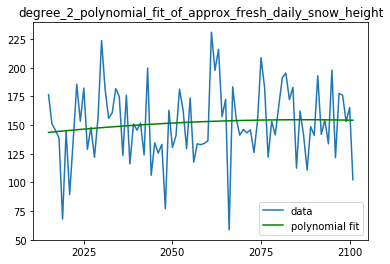

 25%|██▌       | 1/4 [00:37<01:53, 37.73s/it]

percentile: 99


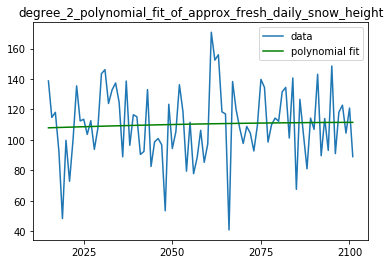

 50%|█████     | 2/4 [00:40<00:54, 27.18s/it]

percentile: 97.5


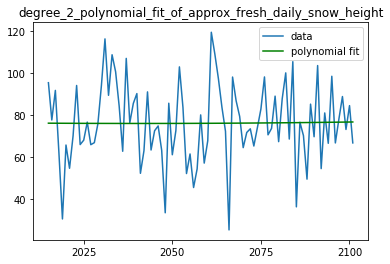

 75%|███████▌  | 3/4 [00:42<00:19, 19.79s/it]

percentile: 95


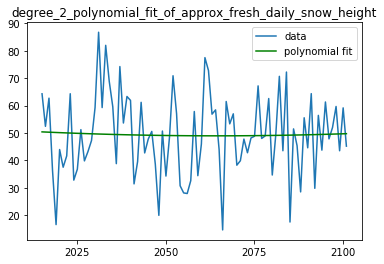

  0%|          | 0/10 [00:00<?, ?it/s]

Plot for threshhold exceedances
100


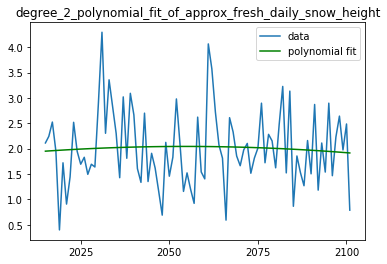

 10%|█         | 1/10 [00:00<00:06,  1.44it/s]

200


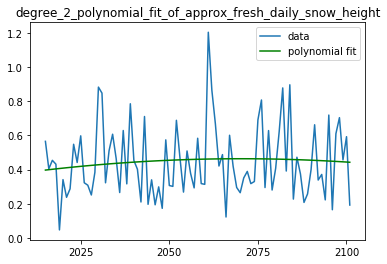

 20%|██        | 2/10 [00:01<00:05,  1.47it/s]

300


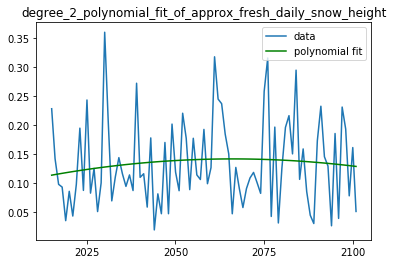

 30%|███       | 3/10 [00:01<00:04,  1.48it/s]

400


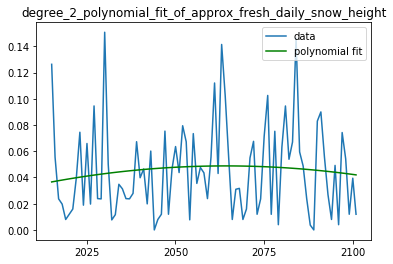

 40%|████      | 4/10 [00:02<00:04,  1.49it/s]

500


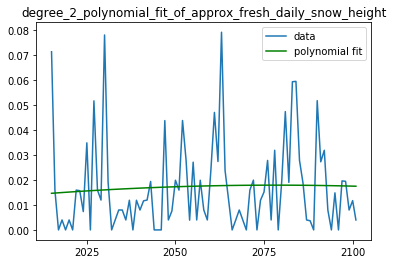

 50%|█████     | 5/10 [00:03<00:03,  1.50it/s]

600


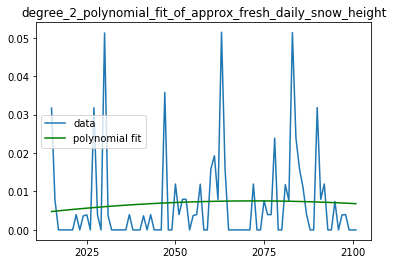

 60%|██████    | 6/10 [00:03<00:02,  1.51it/s]

700


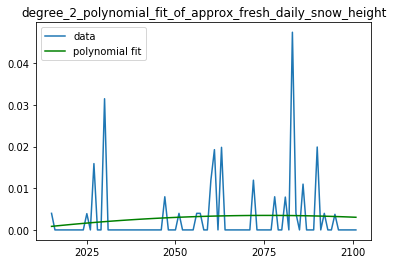

 70%|███████   | 7/10 [00:04<00:01,  1.53it/s]

800


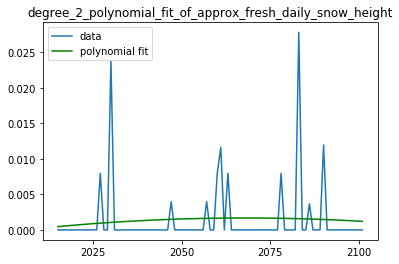

 80%|████████  | 8/10 [00:05<00:01,  1.51it/s]

900


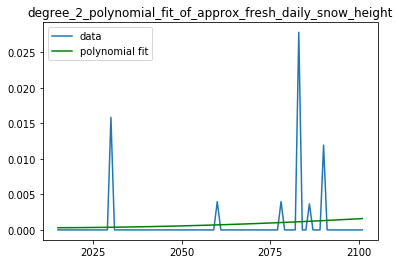

 90%|█████████ | 9/10 [00:05<00:00,  1.52it/s]

1000


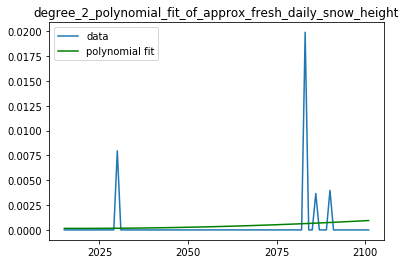

100%|██████████| 10/10 [00:06<00:00,  1.52it/s]
/home/quante/.conda/envs/my_root/lib/python3.6/site-packages/iris/cube.py:3218: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))


Plot max


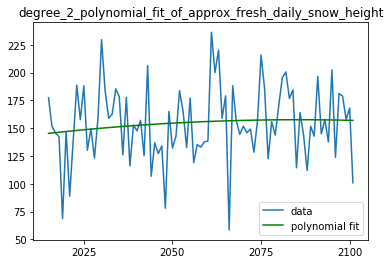

Plot mean


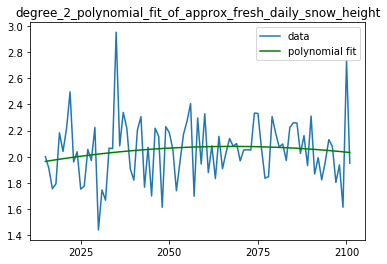

  0%|          | 0/4 [00:00<?, ?it/s]

plot percentiles
percentile: 99.9


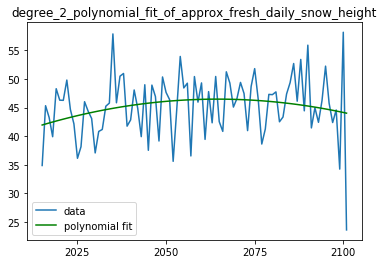

 25%|██▌       | 1/4 [02:06<06:18, 126.11s/it]

percentile: 99


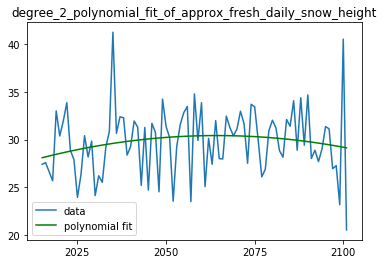

 50%|█████     | 2/4 [03:11<03:35, 107.76s/it]

percentile: 97.5


In [ ]:
cube_stats(germany_winter)
cube_stats(china_winter)
cube_stats(us_winter)